# Estudo de caso

Em 2009, a conferência Knowledge Discovery and Data Mining (KDD) lançou um desafio envolvendo aprendizagem de máquina. Ela disponibilizou dados de consumidores da empresa de telecomunicações francesa Orange, que deveriam ser utilizados para a construção de um modelo capaz de prever três comportamentos do consumidor. A planilha fornecida tem 50000 instâncias e 230 variáveis, sendo as primeiras 190 variáveis numéricas e as demais 40 categóricas. As variáveis de saída do modelo eram o cancelamento da conta ('churn'), a tendência de usar novos produtos e serviços ('appetency') e a propensão para comprar upgrades ou adicionais com maior margem de lucro quando apresentados (upselling), fornecidos de forma binária (-1 para não, 1 para sim).

O trabalho apresentado aqui envolve a criação de um modelo para predição de churn, appetency e upselling com base nos dados fornecidos dos clientes da Orange. O critério para avaliação do modelo será a métrica AUC, que dimensiona o trade-off entre taxa de falsos positivos e taxa de verdadeiros positivos: quanto mais próximo de 1, menor o trade-off e melhor o modelo.

Detalhes sobre a competição: https://www.kdd.org/kdd-cup/view/kdd-cup-2009

# Etapa 1: Modelando o CHURN(cancelamento de conta)
Resposta: **0.6869**


## Importanção das dependencias

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier # 3 algoritmos
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

## Carregando dados

In [ ]:
features = pd.read_csv('/content/drive/MyDrive/IA EXPERT ACADEMY/03. Machine Learning para Competições Kaggle /01. KDD Cup 2009 Previsão do Comportamento de Consumidores/Machine Learning para Competições Kaggle Curso 1/kdd/orange_small_train.data', sep = '\t', na_filter = False) # São os atributos previsores
outcome = pd.read_csv('/content/drive/MyDrive/IA EXPERT ACADEMY/03. Machine Learning para Competições Kaggle /01. KDD Cup 2009 Previsão do Comportamento de Consumidores/Machine Learning para Competições Kaggle Curso 1/kdd/orange_small_train_churn.labels', header = None) # é a variavel TARGET

In [ ]:
features.shape, outcome.shape

((50000, 230), (50000, 1))

As categorias foram criptografadas para que seja mais dificil de encontrar relações e preservar a privacidade dos usuarios

In [ ]:
features.head(3)

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,,,,,,1526,7,,,,...,oslk,fXVEsaq,jySVZNlOJy,,,xb3V,RAYp,F2FyR07IdsN7I,,
1,,,,,,525,0,,,,...,oslk,2Kb5FSF,LM8l689qOp,,,fKCe,RAYp,F2FyR07IdsN7I,,
2,,,,,,5236,7,,,,...,Al6ZaUT,NKv4yOc,jySVZNlOJy,,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,


In [ ]:
outcome.head(3)

,0
0,-1
1,1
2,-1


In [ ]:
np.unique(outcome) # Confirmando que so temos 1 e -1

array([-1,  1])

## Identificando as variáveis numéricas e categóricas

In [ ]:
all_vars = np.array(features.columns)
all_vars

array(['Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Var6', 'Var7', 'Var8',
       'Var9', 'Var10', 'Var11', 'Var12', 'Var13', 'Var14', 'Var15',
       'Var16', 'Var17', 'Var18', 'Var19', 'Var20', 'Var21', 'Var22',
       'Var23', 'Var24', 'Var25', 'Var26', 'Var27', 'Var28', 'Var29',
       'Var30', 'Var31', 'Var32', 'Var33', 'Var34', 'Var35', 'Var36',
       'Var37', 'Var38', 'Var39', 'Var40', 'Var41', 'Var42', 'Var43',
       'Var44', 'Var45', 'Var46', 'Var47', 'Var48', 'Var49', 'Var50',
       'Var51', 'Var52', 'Var53', 'Var54', 'Var55', 'Var56', 'Var57',
       'Var58', 'Var59', 'Var60', 'Var61', 'Var62', 'Var63', 'Var64',
       'Var65', 'Var66', 'Var67', 'Var68', 'Var69', 'Var70', 'Var71',
       'Var72', 'Var73', 'Var74', 'Var75', 'Var76', 'Var77', 'Var78',
       'Var79', 'Var80', 'Var81', 'Var82', 'Var83', 'Var84', 'Var85',
       'Var86', 'Var87', 'Var88', 'Var89', 'Var90', 'Var91', 'Var92',
       'Var93', 'Var94', 'Var95', 'Var96', 'Var97', 'Var98', 'Var99',
       'Var100', 'Va

In [ ]:
var_numericas = np.array(all_vars[:190])
var_categoricas = np.array(all_vars[190:])

## Tratando valores faltantes e alterando os tipos que estavam errados

In [ ]:
features.dtypes

Var1      object
Var2      object
Var3      object
Var4      object
Var5      object
           ...  
Var226    object
Var227    object
Var228    object
Var229    object
Var230    object
Length: 230, dtype: object

In [ ]:
# Substituindo os valores faltantes por NaN
features = features.replace('', np.nan)

In [ ]:
features.head(3)

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526,7,NaN,NaN,NaN,...,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525,0,NaN,NaN,NaN,...,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236,7,NaN,NaN,NaN,...,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN


In [ ]:
for col in var_numericas:
  features[col] = features[col].astype('float') # Tranformando os valores das numericas em float
for col in var_categoricas:
  features[col] = features[col].astype('category') # category:  usado para representar uma variável categórica com um número limitado de valores únicos.

In [ ]:
features.dtypes

Var1       float64
Var2       float64
Var3       float64
Var4       float64
Var5       float64
            ...   
Var226    category
Var227    category
Var228    category
Var229    category
Var230    category
Length: 230, dtype: object

## Seleção dos atributos

### Variaveis com muitos valores faltantes


In [ ]:
null_per_columns =features.isnull().sum()
null_per_columns.head()

Var1    49298
Var2    48759
Var3    48760
Var4    48421
Var5    48513
dtype: int64

48513.0


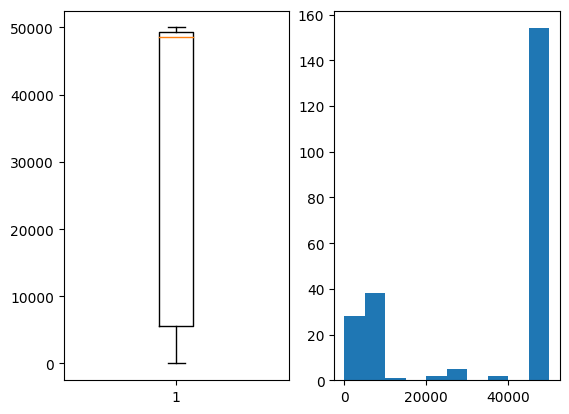

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2) # dois graficos, 1 linha e duas colunas
ax1.boxplot(null_per_columns)
ax2.hist(null_per_columns)
median = null_per_columns.median()
print(median)

Como nao conhecemos os dados bem a ponto de poder substituir os valores faltantes, a melhor estrategia a ser utilizada é apagar as colunas cujos valores faltantes são muito altos, ficando aassim com os valores do canto esquerdo. Vamos utilizar 25% do total de instancias, ou seja, utilizar colunas que tenham no maximo 10000 valores faltantes(NaN)


In [ ]:
num_entries = len(features)
threshold = 0.25
num_entries * threshold # Vamos excluir as variaveis com mais de 12500 valores faltantes

12500.0

In [ ]:
# Aplicando o fltro
keep_vars = np.array(features.columns[(null_per_columns <= (num_entries * threshold))])
len(keep_vars)

66

In [ ]:
# Vamos atualizar as variaveis numericas e categoricas
var_numericas = [element for element in var_numericas if element in keep_vars]
var_categoricas = [element for element in var_categoricas if element in keep_vars]
len(var_numericas), len(var_categoricas)

(38, 28)

In [ ]:
# Substituindo as NaN pelo valor da media(variaveis numericas)
for col in var_numericas:
  col_mean = features[col].mean()
  features[col] = features[col].fillna(col_mean) # Mudando no DF

# Substituindo NaN por missing(variaveis categoricas)
for col in var_categoricas:
  features[col] = features[col].cat.add_categories('missing') # isso pq o tipo de dados é categoria
  features[col] = features[col].fillna('missing')# Mudando no DF

### Variáveis categóricas com muitas categorias

In [ ]:
categorias_per_columns = features[var_categoricas].apply(lambda x:len(set(x))) # Vai retornar os valores unicos, ou seja, a quantidade de categorias
categorias_per_columns

Var192      362
Var193       51
Var195       23
Var196        4
Var197      226
Var198     4291
Var199     5074
Var202     5714
Var203        6
Var204      100
Var205        4
Var206       22
Var207       14
Var208        3
Var210        6
Var211        2
Var212       81
Var216     2016
Var217    13991
Var218        3
Var219       23
Var220     4291
Var221        7
Var222     4291
Var223        5
Var226       23
Var227        7
Var228       30
dtype: int64

(array([21.,  1.,  0.,  4.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([2.00000e+00, 1.40090e+03, 2.79980e+03, 4.19870e+03, 5.59760e+03,
        6.99650e+03, 8.39540e+03, 9.79430e+03, 1.11932e+04, 1.25921e+04,
        1.39910e+04]),
 <BarContainer object of 10 artists>)

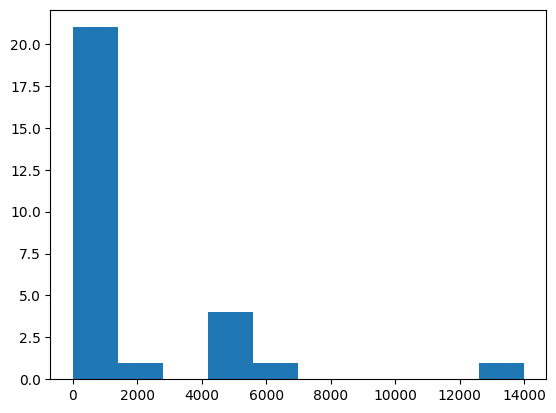

In [ ]:
plt.hist(x=categorias_per_columns)

Vamos pegar os registros que se encaixam na primeira faixa, que são aqueles que não tem uma quantidade muito grande de variaveis

In [ ]:
var_categoricas = np.array(categorias_per_columns[categorias_per_columns < 1400].index)
len(var_categoricas)

21

### Excluindo do DF as variaveis que foram podadas

In [ ]:
features = features[list(var_numericas) + list(var_categoricas)]

In [ ]:
features.shape

(50000, 59)

In [ ]:
features.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var210,Var211,Var212,Var218,Var219,Var221,Var223,Var226,Var227,Var228
0,1526.000000,7.0,184.0,464.000000,580.0,14.000000,128.0,166.56,0.0,3570.0,...,uKAI,L84s,XfqtO3UdzaXh_,cJvF,FzaX,oslk,jySVZNlOJy,xb3V,RAYp,F2FyR07IdsN7I
1,525.000000,0.0,0.0,168.000000,210.0,2.000000,24.0,353.52,0.0,4764966.0,...,uKAI,L84s,NhsEn4L,missing,FzaX,oslk,LM8l689qOp,fKCe,RAYp,F2FyR07IdsN7I
2,5236.000000,7.0,904.0,1212.000000,1515.0,26.000000,816.0,220.08,0.0,5883894.0,...,uKAI,L84s,UbxQ8lZ,UYBR,FzaX,Al6ZaUT,jySVZNlOJy,Qu4f,02N6s8f,ib5G6X1eUxUn6
3,1326.437116,0.0,0.0,234.518225,0.0,4.507926,0.0,22.08,0.0,0.0,...,uKAI,Mtgm,NhsEn4L,UYBR,FzaX,oslk,LM8l689qOp,FSa2,RAYp,F2FyR07IdsN7I
4,1029.000000,7.0,3216.0,64.000000,80.0,4.000000,64.0,200.00,0.0,0.0,...,uKAI,L84s,XfqtO3UdzaXh_,UYBR,FzaX,oslk,LM8l689qOp,FSa2,RAYp,F2FyR07IdsN7I


### Seleção de variáveis baseada em árvore de decisão

arvore de decisão vai selecionar os atributos mais importantes para esse DataFrame

Vamos criar variaveis do tipo dummies, que basicamente vamos fazer uma especie de OneHotEncoder

In [ ]:
features_c = pd.get_dummies(features)

In [ ]:
features_c.shape


(50000, 1052)

Aumenta bastante a dimensionalidade dos dados

In [ ]:
features_c.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var228__cTCyH95OE93jSkoIBT,Var228_am14IcfM7tWLrUmRT52KtA,Var228_b9qbUNk0dML_Mvi2,Var228_d0LtHjWeaXyArdN4sxU_saXqH,Var228_ib5G6X1eUxUn6,Var228_iyHGyLCEkQ,Var228_n1OBWGkV3fbsHR75taC,Var228_r_7E,Var228_xwM2aC7IdeMC0,Var228_missing
0,1526.000000,7.0,184.0,464.000000,580.0,14.000000,128.0,166.56,0.0,3570.0,...,0,0,0,0,0,0,0,0,0,0
1,525.000000,0.0,0.0,168.000000,210.0,2.000000,24.0,353.52,0.0,4764966.0,...,0,0,0,0,0,0,0,0,0,0
2,5236.000000,7.0,904.0,1212.000000,1515.0,26.000000,816.0,220.08,0.0,5883894.0,...,0,0,0,0,1,0,0,0,0,0
3,1326.437116,0.0,0.0,234.518225,0.0,4.507926,0.0,22.08,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1029.000000,7.0,3216.0,64.000000,80.0,4.000000,64.0,200.00,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def importances_features(features, outcome): # outcome é o resultado(target)
  model = ExtraTreesClassifier(n_estimators = 200, criterion='entropy', verbose=0)
  model.fit(features, np.array(outcome).ravel()) # Ravel coloca no formato de vetor, antes tava em formato de matriz

  importances = model.feature_importances_ # Para cada variavel retorna sua importancia
  variables = np.array(features.columns)
  indices = np.argsort(importances)[::-1] # Retorna em ordem decrescente
  importances = importances[indices] # Torna a variavel importances ordenada
  variables = variables[indices]# Torna a variablels importances ordenada

  return variables, importances

In [ ]:
variables, importances = importances_features(features_c, outcome)

In [ ]:
importances # Lita com a importancia de cada variavel

array([0.01788913, 0.01763322, 0.01745927, ..., 0.        , 0.        ,
       0.        ])

In [ ]:
variables

array(['Var57', 'Var73', 'Var113', ..., 'Var219_kgEg', 'Var193_OpDzzQJ',
       'Var228_missing'], dtype=object)

In [ ]:
importances[-1]

0.0

Percebemos que existem variaveis com importancia 0, ou seja, precisamos tirar essas que nao tem significancia para o nosso modelo

In [ ]:
# Vendo o numero ideal de atributos que devemos usar
def df_importances(variables, importances):
  sum_importances = pd.DataFrame() # Definimos um novo datafrane
  for i in range(importances.size):
    importancia_atual = importances[: (i+1)].sum() # Vai retornar a porcentagem de importancia acumulada para a variavel atual
    this_variable = pd.Series([variables[i], importancia_atual]) # cria uma serie com a variavel atual e sua importancia
    sum_importances = sum_importances.append(this_variable, ignore_index= True)
  return sum_importances

In [ ]:
df_importances = df_importances(variables, importances)

<ipython-input-34-36667b24866a>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sum_importances = sum_importances.append(this_variable, ignore_index= True)
<ipython-input-34-36667b24866a>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sum_importances = sum_importances.append(this_variable, ignore_index= True)
<ipython-input-34-36667b24866a>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sum_importances = sum_importances.append(this_variable, ignore_index= True)
<ipython-input-34-36667b24866a>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sum_importances = sum_importances.append(this_variable, ignore_index= True)
<ipython-input-3

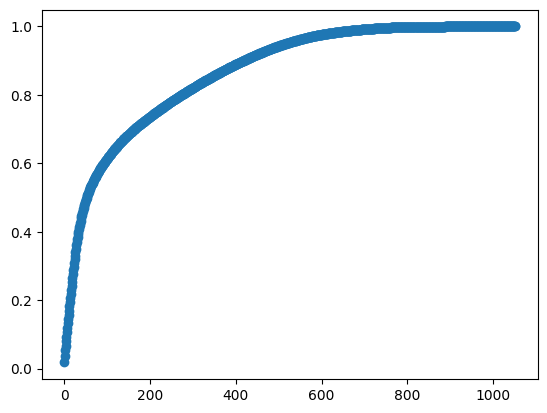

In [ ]:
plt.scatter(df_importances.index, df_importances.iloc[:, 1]) # Vamos plotar a porcentagem de importancia acumulada para saber quando podemos parar de pegar variaveis

A partir da variavel 750, temos um valor que representa 100% de importancia, logo, apos 750, os atributos nao surtem efeito no modelo

In [ ]:
# Função para podar as variaveis que nao tem importancia significativa
def keep_vars(features, sum_importances, threshold): # threshold é o ponto no qual vamos parar de considerar as variaveis
  keep_vars = list(sum_importances[sum_importances.iloc[:, 1] <= threshold].iloc[:, 0]) # Vai pegar apenas as variaveis que possuem valor de importancia acumulada menor  que o threshold
  features = features.loc[:, keep_vars] # Vai filtrar a base de dados

  return features

In [ ]:
# Vamos chamar a função para o nosso df de features
features_c = keep_vars(features_c, df_importances, 0.99)

In [ ]:
features_c.shape

(50000, 683)

In [ ]:
features_c.head(3)

,Var57,Var73,Var113,Var81,Var153,Var133,Var38,Var134,Var76,Var28,...,Var228_DU8B,Var197_EbEb,Var212_fnfcPDe,Var219_FqMWi1g,Var212_6z7lZp6XhQkon,Var195_ArtjQZQO1r9fC,Var207_6C53VA1kCv,Var197_gEzH,Var192_dPsBcmRZ57,Var192_czzTmBGxe3
0,4.076907,36.0,117625.6,7333.11,1812252.0,1212385.0,3570.0,69134.0,1350864.0,166.56,...,0,0,0,0,0,0,0,0,0,0
1,5.408032,26.0,-356411.6,151098.90,10439160.0,4136430.0,4764966.0,357038.0,2872928.0,353.52,...,0,0,0,0,0,0,0,0,0,0
2,6.599658,130.0,405104.0,16211.58,9826360.0,3478905.0,5883894.0,248932.0,1675776.0,220.08,...,0,0,0,0,0,0,0,0,0,0


## Dividindo os dados em treino e test

In [ ]:
def split_df(features, outcome, test_size=0.2):
  X_train, X_test, y_train, y_test = train_test_split(features, outcome, test_size = test_size,
                                                      stratify = outcome, random_state = 0)
  y_train, y_test = np.array(y_train).ravel(), np.array(y_test).ravel() # Isso pq queremos que y_train/test seja em forma de array e nao em matriz como eh a saida do train_test_split

  return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = split_df(features_c, outcome)

In [ ]:
X_train.shape, X_test.shape

((40000, 683), (10000, 683))

In [ ]:
y_train.shape, y_test.shape

((40000,), (10000,))

## Modelagem preliminar

### Random Forest

In [ ]:
def rf_test(X_train, y_train, n_estimators = 100, cv = 5): # CV é para saber em quantos pedaços vamos quebrar nossa base de dados para efetuar a validação cruzada
  np.random.seed(0)
  rf = RandomForestClassifier(n_estimators = n_estimators, random_state = 0, n_jobs = -1) # n_jobs é o numero de processos que vao ser executados paralelamento(-1 é o maximo possivel)
  cv_socres = cross_val_score(rf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
  print(f'Media dos 5 testes: {cv_socres.mean()}')

No caso da validação cruzada, ela divide a base de dados em treino e teste e faz o treinamento com a primeira subdivisao e o teste com a segunda, logo, nao tem problema em mandar apenas o X_train e y_ttain pra ela, pois ela fara uma divisão de modo a analisar o resultado com clareza

In [ ]:
rf_test(X_train, y_train)

Media dos 5 testes: 0.6298263626633879


## Gradient Boosting Classifier

In [ ]:
def gbc_test(X_train, y_train, n_estimators = 100, learning_rate = 0.1, cv = 5):
  np.random.seed(0)
  gbc = GradientBoostingClassifier(n_estimators = n_estimators, learning_rate = learning_rate, random_state = 0)
  cv_socres = cross_val_score(gbc, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
  print(f'Media dos 5 testes: {cv_socres.mean()}')

In [ ]:
gbc_test(X_train, y_train)

Media dos 5 testes: 0.6716755786521377


O modelo GradientBoostingClassifier apresentou um resultado significativamente maior do que random forest, então ele será o escolhido a ser otimizado

## Otimizando o modelo GBC(GradientBoostingClassifier)

### Otimizando `n_estimators` para `learning_rate` = 0.1

Faremos uma função geral para calcular o melhor parametro de cada um dos parametros. Colocaremos valores em todos menos no qual queremos calcular, neste colocaremos None, e a função retornará qual o valor mais eficiente para o mesmo


In [ ]:
def optimize(n_estimators, learning_rate, min_samples_split, min_samples_leaf, max_depth, max_features, subsample, params, cv = 5): # Passaremos os parametros do GBC
  np.random.seed(0)
  gbc = GradientBoostingClassifier(n_estimators = n_estimators,learning_rate = learning_rate,min_samples_split = min_samples_split,min_samples_leaf = min_samples_leaf,max_depth = max_depth,max_features = max_features, subsample = subsample,random_state = 0)

  # Usaremos GridSearchCV: Tecnica que usa validação cruzada para fazer a combinação e teste com varios parametros e vai retornar o melhor deles
  grid_search = GridSearchCV(estimator = gbc, param_grid = params, scoring = 'roc_auc',n_jobs = -1, cv = cv) # Param_grid é a lista de parametros que ele irá testar
  grid_search.fit(X_train, y_train)

  melhores_parametros = grid_search.best_params_
  melhor_resultado = grid_search.best_score_
  print(melhores_parametros, melhor_resultado)

  return gbc, melhores_parametros, melhor_resultado

In [ ]:
# Variavel para armazenar os resultados
models = np.array([]) # Armazenar os modelos que estamos retornando
opt_paramns = dict() # Os parametros ja calculados
scores = np.array([])

In [ ]:
# Modelo 0 - vamos passar os parametros iniciais e passar como None o parametro que desejamos calcular por meio da função
# Os valores dos parametros que ainda nao calculamos serão os default da biblioteca
learning_rate = 0.1
n_estimators = None
max_depth = 8
min_samples_split = 250
min_samples_leaf = 20
max_features = 'sqrt'
subsample = 0.8
params = {'n_estimators': range(50, 151, 10)} # Armazena o espaço no qual queremos que a função execute, de 50 a 150 pulando de 10 em 10

In [ ]:
gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'n_estimators': 50} 0.6668954904118618


In [ ]:
models = np.append(models, gbc)
opt_paramns = {**opt_paramns, **opt_param} # Unir dois dicts
scores = np.append(scores, score) # Unir duas listas

In [ ]:
models

array([GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                                  min_samples_leaf=20, min_samples_split=250,
                                  n_estimators=None, random_state=0, subsample=0.8)],
      dtype=object)

In [ ]:
opt_paramns

{'n_estimators': 50}

In [ ]:
scores

array([0.66689549])

### Otimizando `max_depth` e `min_samples_split`

In [ ]:
# Modelo 1
n_estimators = opt_paramns['n_estimators']
learning_rate = 0.1
max_depth = None
min_samples_split = None
min_samples_leaf = 20
max_features = 'sqrt'
subsample = 0.8
params = {'max_depth': range(3, 12, 2),
          'min_samples_split': range(150, 401, 50)}

In [ ]:
gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'max_depth': 9, 'min_samples_split': 400} 0.6712853231412246


In [ ]:
models = np.append(models, gbc)
opt_paramns = {**opt_paramns, **opt_param} # Unir dois dicts
scores = np.append(scores, score) # Unir duas listas

In [ ]:
opt_paramns

{'n_estimators': 50, 'max_depth': 9, 'min_samples_split': 400}

In [ ]:
scores

array([0.66689549, 0.67128532])

### Otimizando `min_samples_leaf`

In [ ]:
n_estimators = opt_paramns['n_estimators']
learning_rate = 0.1
max_depth = opt_paramns['max_depth']
min_samples_split = opt_paramns['min_samples_split']
min_samples_leaf = None
max_features = 'sqrt'
subsample = 0.8
params = {'min_samples_leaf': range(25, 61, 5)}

In [ ]:
gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'min_samples_leaf': 55} 0.6726248902516749


In [ ]:
models = np.append(models, gbc)
opt_paramns = {**opt_paramns, **opt_param} # Unir dois dicts
scores = np.append(scores, score) # Unir duas listas

In [ ]:
opt_paramns

{'n_estimators': 50,
 'max_depth': 9,
 'min_samples_split': 400,
 'min_samples_leaf': 55}

### Otimizando `max_features`

In [ ]:
n_estimators = opt_paramns['n_estimators']
learning_rate = 0.1
max_depth = opt_paramns['max_depth']
min_samples_split = opt_paramns['min_samples_split']
min_samples_leaf = opt_paramns['min_samples_leaf']
max_features = None
subsample = 0.8
params = {'max_features': range(25, 61, 5)}

In [ ]:
gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'max_features': 30} 0.6702703617712804


In [ ]:
models = np.append(models, gbc)
opt_paramns = {**opt_paramns, **opt_param} # Unir dois dicts
scores = np.append(scores, score) # Unir duas listas

In [ ]:
opt_paramns

{'n_estimators': 50,
 'max_depth': 9,
 'min_samples_split': 400,
 'min_samples_leaf': 55,
 'max_features': 30}

### Otimizando `subsample`

In [ ]:
n_estimators = opt_paramns['n_estimators']
learning_rate = 0.1
max_depth = opt_paramns['max_depth']
min_samples_split = opt_paramns['min_samples_split']
min_samples_leaf = opt_paramns['min_samples_leaf']
max_features = opt_paramns['max_features']
subsample = None
params = {'subsample': np.append(np.arange(0.6, 1, 0.05), 1)} # (Sttart stop step) Temos que colocar o 1 pra ele ir ate o 1

In [ ]:
gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

{'subsample': 0.8500000000000002} 0.6733873957495218


In [ ]:
models = np.append(models, gbc)
opt_paramns = {**opt_paramns, **opt_param} # Unir dois dicts
scores = np.append(scores, score) # Unir duas listas

In [ ]:
opt_paramns

{'n_estimators': 50,
 'max_depth': 9,
 'min_samples_split': 400,
 'min_samples_leaf': 55,
 'max_features': 30,
 'subsample': 0.8500000000000002}

{'n_estimators': 50,
 'max_depth': 7,
 'min_samples_split': 350,
 'min_samples_leaf': 60,
 'max_features': 55,
 'subsample': 0.8000000000000002}

### Otimizando `n_estimators` e `learning_rate`

Vamos combinar os dois parametros pra achar qual é a dupla que representa melhor eles


In [ ]:
def optimize2(n_estimators, learning_rate, min_samples_split, min_samples_leaf, max_depth, max_features, subsample, cv = 5): # Passaremos os parametros do GBC
  np.random.seed(0)
  gbc = GradientBoostingClassifier(n_estimators = n_estimators,learning_rate = learning_rate,min_samples_split = min_samples_split,min_samples_leaf = min_samples_leaf,max_depth = max_depth,max_features = max_features, subsample = subsample,random_state = 0)

  # ao inves de usar GridSearchCV, vamos usar a validação cruzada direta
  cv_scores = cross_val_score(gbc, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
  score_cv = cv_scores.mean()
  plt.plot(np.append(scores, score_cv)) # Score é a variavel que armazena os resultados das melhorias anteriores
  plt.title(f'n_estimator: {n_estimators} / learning rate = {learning_rate}')
  return gbc, score_cv

In [ ]:
n_estimators = 50 # Calculado anteriormente
learning_rate = 0.1

max_depth = opt_paramns['max_depth']
min_samples_split = opt_paramns['min_samples_split']
min_samples_leaf = opt_paramns['min_samples_leaf']
max_features = opt_paramns['max_features']
subsample = max_features = opt_paramns['subsample']

In [ ]:
# Modelo 5
# Mudamos essas variaveis proporcionamente(inversamente)
learning_rate /= 2
n_estimators *= 2

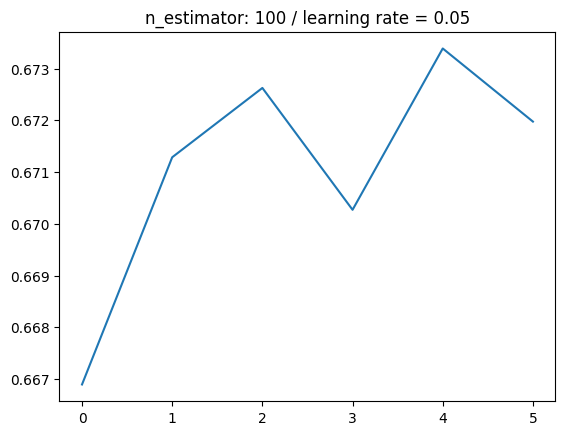

In [ ]:
gbc, score = optimize2(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample)

In [ ]:
scores

array([0.66689549, 0.67128532, 0.67262489, 0.67027036, 0.6733874 ])

In [ ]:
models = np.append(models, gbc)
scores = np.append(scores, score) # Unir duas listas

In [ ]:
# Modelo 6 -- atualizando learning_rate e n_estimators
learning_rate /= 10
n_estimators *= 10

In [ ]:
gbc, score = optimize2(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample)

In [ ]:
models = np.append(models, gbc)
scores = np.append(scores, score) # Unir duas listas

In [ ]:
print(f'Modelo de melhor desempenho: {scores.argmax()}, - AUC: {max(scores)}')

Modelo de melhor desempenho: 4, - AUC: 0.6733873957495218



 os melhores parametros foram: {'n_estimators': 1000,
  'learning_rate': 0.005
 'max_depth': 9,
 'min_samples_split': 400,
 'min_samples_leaf': 55,
 'max_features': 30,
 'subsample': 0.8500000000000002}

In [ ]:
# Treinando o modelo com os melhores parametros
gbc = GradientBoostingClassifier(n_estimators = 1000,learning_rate = 0.005,min_samples_split = 400,min_samples_leaf = 55,
                                 max_depth =  9,max_features = 30, subsample = 0.8500000000000002,random_state = 0)

In [ ]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.005, max_depth=9, max_features=30,
                           min_samples_leaf=55, min_samples_split=400,
                           n_estimators=1000, random_state=0,
                           subsample=0.8500000000000002)

In [ ]:
# Agora vamos fazer as previsões na variavel teste
y_pred_probs = gbc.predict_proba(X_test) # Vai retornar a probabilidade de um registro pertercer a cada classe(proba classe 1, prob classse 2)
y_pred_probs

array([[0.83260748, 0.16739252],
       [0.96805516, 0.03194484],
       [0.94596952, 0.05403048],
       ...,
       [0.94380196, 0.05619804],
       [0.93781709, 0.06218291],
       [0.87270117, 0.12729883]])

In [ ]:
roc_auc_score(y_test, y_pred_probs[:,1])

0.6869227159031494

In [ ]:
previsoes = gbc.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(previsoes, y_test)

0.9267

A resposta final para o desafio foi: 0.6869227159031494